# UCI dataset processing

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

### Data extracting

#### Labels:

In [90]:
labels_name = dict()
train_labels = []
test_labels = []

# Get all class names
with open('./uci/activity_labels.txt') as f:
        for line in f:
            line = line.split()
            labels_name[int(line[0]) - 1] = line[1]

# Get labels for train set
with open('./uci/train/y_train.txt') as f:
    for line in f:
        train_labels.append(int(line))
train_labels = np.array(train_labels) - 1

# Get labels for test set
with open('./uci/test/y_test.txt') as f:
    for line in f:
        test_labels.append(int(line))
test_labels = np.array(test_labels) - 1

print('Classes:', list(labels_name.values()))
print('Samples:', test_labels.shape[0] + train_labels.shape[0])
print()
print('Number of train samples:', train_labels.shape[0])
print('Number of test samples:', test_labels.shape[0])
print()
print('Train/Test ratio:', test_labels.shape[0]/train_labels.shape[0])

Classes: ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
Samples: 10299

Number of train samples: 7352
Number of test samples: 2947

Train/Test ratio: 0.40084330794341677


<hr>

#### Data:

In [132]:
train_data = []

# Get X-axis data for train set
data_axis = []
with open('./uci/train/Inertial Signals/body_acc_x_train.txt') as f:
    for line in f:
        vals = [float(val) for val in line.split()]
        data_axis.append(np.array(vals))
train_data.append(data_axis)

# Get Y-axis data for train set
data_axis = []
with open('./uci/train/Inertial Signals/body_acc_y_train.txt') as f:
    for line in f:
        vals = [float(val) for val in line.split()]
        data_axis.append(np.array(vals))
train_data.append(data_axis)

# Get Z-axis data for train set
data_axis = []
with open('./uci/train/Inertial Signals/body_acc_z_train.txt') as f:
    for line in f:
        vals = [float(val) for val in line.split()]
        data_axis.append(np.array(vals))
train_data.append(data_axis)

train_data = np.array(train_data)
train_data = (train_data[0]**2 + train_data[1]**2 + train_data[2]**2) ** 0.5

print('Train set shape:', train_data.shape)

Train set shape: (7352, 128)


In [133]:
test_data = []

data_axis = []
with open('./uci/test/Inertial Signals/body_acc_x_test.txt') as f:
    for line in f:
        vals = [float(val) for val in line.split()]
        data_axis.append(np.array(vals))
test_data.append(data_axis)

data_axis = []
with open('./uci/test/Inertial Signals/body_acc_y_test.txt') as f:
    for line in f:
        vals = [float(val) for val in line.split()]
        data_axis.append(np.array(vals))
test_data.append(data_axis)

data_axis = []
with open('./uci/test/Inertial Signals/body_acc_z_test.txt') as f:
    for line in f:
        vals = [float(val) for val in line.split()]
        data_axis.append(np.array(vals))
test_data.append(data_axis)

test_data = np.array(test_data)
test_data = (test_data[0]**2 + test_data[1]**2 + test_data[2]**2) ** 0.5

print('Test set shape:', test_data.shape)

Test set shape: (2947, 128)


<hr>

In [506]:
def cubic_smooth(segments,
                 output_length=None):
    """Calculates mean and std of passed segments. Since the sizes might vary,
    the cubic spline interpolation is performed.

    :param segments: Iterable[np.ndarray]. Iterable of segments.
    :param output_length: The desired length of the segment to convert to.
    :return: Pair of np.ndarrays.
    """
    segments = list(segments)

    if not output_length:
        lengths = [len(s) for s in segments]
        output_length = sorted(lengths)[len(lengths) // 2]

    segments_matrix = np.zeros((len(segments), output_length))
    output_indices = np.arange(output_length)

    for idx, segment in enumerate(segments):
        # TODO: use normalize module to do this routine.
        segment_indices = np.arange(len(segment))
        f = scipy.interpolate.interp1d(segment_indices, segment, kind='cubic')

        extrapolate_indices = (output_indices *
                               (segment_indices[-1] / output_indices[-1]))
        extrapolate_indices[-1] = segment_indices[-1]

        segments_matrix[idx, :] = f(extrapolate_indices)

    return (np.mean(segments_matrix, axis=0),
            np.std(segments_matrix, axis=0))

In [134]:
def stitch_data(data, labels):
    prev = None
    activities = []
    classes = []
    for i in range(labels.shape[0]):
        if labels[i] != prev:
            classes.append(labels[i])
            prev = labels[i]
            activities.append(list(data[i]))
        else:
            activities[-1] = activities[-1] + list(data[i][64:])
    return activities, classes

In [135]:
activities, classes = stitch_data(train_data, train_labels)
len(activities)

280

In [130]:
len(activities[0])

1792

In [517]:
tmp = find_local_extrema(np.array(activities[11]), 21)

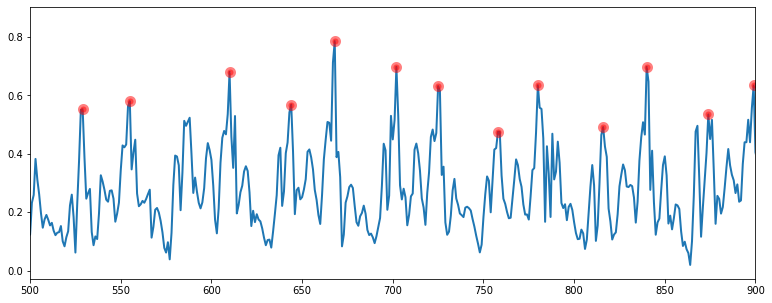

0 WALKING


In [518]:
i = 11

plt.figure(figsize=(13, 5))
plt.plot(activities[i], linewidth=2, zorder=0)
plt.scatter(np.arange(0, len(activities[i]))[tmp],
            np.array(activities[i])[tmp],
            c='r',
            alpha=0.5,
            linewidths=5)

plt.xlim(xmin=500, xmax=900)
plt.show()

print(classes[i], labels_name[classes[i]])

In [519]:
np.std(np.array(activities[i])) + np.mean(np.array(activities[i]))

0.4347928635772837

In [286]:
def find_local_extrema(array: np.ndarray, radius: int):
    output = np.array([False] * len(array))
    for idx, val in enumerate(array):
        indexes = np.array([x
                            for x in range(idx - radius, idx + radius + 1)
                            if x > 0 and x < len(array)])
        output[idx] = array[idx] >= np.max(array[indexes])
    return output

def extract_segment_bounds(x,
                           max_threshold,
                           min_segment_size,
                           max_segment_size=10e8,
                           radius=1):
    # We take only those which have left and right neighbour
    indices = list(range(x.shape[0]))[1:-1]
    idx_local_maxima = np.where(find_local_extrema(x, radius))[0]
    idx_above_threshold = (idx for idx in idx_local_maxima if x[idx] > max_threshold)
    idx_maxima = list(idx_above_threshold)
    idx_segments = [(idx_maxima[i], idx_maxima[i + 1]) for i in range(len(idx_maxima) - 1)]
    big_enough_segments = [pair for pair in idx_segments
                           if (pair[1] - pair[0] >= min_segment_size
                               and pair[1] - pair[0] <= max_segment_size)]
    return big_enough_segments  

In [303]:
from scipy.interpolate import interp1d

def shrink_segment(segment, output_length):
    segment_indices = np.arange(segment.size)
    interpolated_f = interp1d(segment_indices,
                                                segment,
                                                kind='cubic')
    new_indices = np.linspace(0, segment_indices[-1], output_length)
    return interpolated_f(new_indices)


def normalize_segments(segments,
                       length=None):
    segments = list(segments)
    length = length if length else min(segment.size for segment in segments)
    return [shrink_segment(segment, length) for segment in segments]

In [306]:
labels_name

{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING'}

In [483]:
segments = dict.fromkeys(labels_name.values())

for i in range(len(activities)):
    a = np.array(activities[i])
    c = classes[i]
    if c < 3:
        tmp = extract_segment_bounds(a, a.mean() + a.std(), 20, 90, radius=21)
        tmp_a = [a[first:second] for first, second in tmp]
        if segments[labels_name[c]] is None:
            segments[labels_name[c]] = list()
        segments[labels_name[c]] += tmp_a
    else:
        tmp = extract_segment_bounds(a, a.mean() - 0.03, 21, 30, radius=9)
        tmp_a = [a[first:second] for first, second in tmp]
        if segments[labels_name[c]] is None:
            segments[labels_name[c]] = list()
        segments[labels_name[c]] += tmp_a

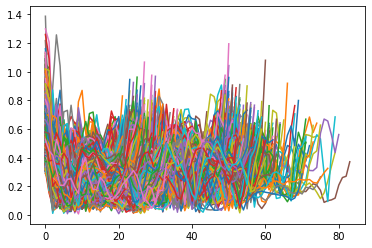

In [484]:
for segment in segments['WALKING']:
    plt.plot(segment)

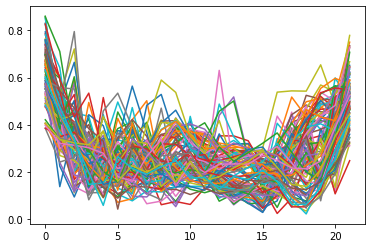

In [538]:
normalized_segments = normalize_segments(segments['WALKING'][100:200])

for segment in normalized_segments:
    plt.plot(segment)

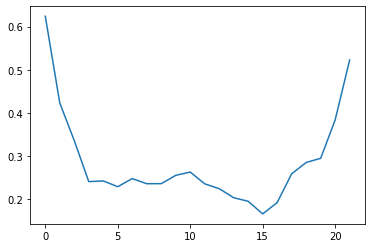

In [539]:
tmp = cubic_smooth(normalized_segments)

plt.plot(tmp[0])

In [486]:
for act in segments:
    print(len(segments[act]))

2207
2037
2063
1081
1189
1065


In [502]:
action_and_segment = []

for key, segments_array in segments.items():
    action_and_segment.extend([(key, s) for s in segments_array if s.size > 20])
    
with open("./uci/activity_and_segment.pickle", "wb") as f:
    pickle.dump(action_and_segment, f)